# Config

In [1]:
import os
import json
import time
import torch
import pprint
import random
import pandas
import argparse
import lightning


import numpy as np
import mdtraj as md
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from torch.utils.data import Dataset

In [2]:
def compute_dihedral(positions):
	"""http://stackoverflow.com/q/20305272/1128289"""
	def dihedral(p):
		if not isinstance(p, np.ndarray):
			p = p.numpy()
		b = p[:-1] - p[1:]
		b[0] *= -1
		v = np.array([v - (v.dot(b[1]) / b[1].dot(b[1])) * b[1] for v in [b[0], b[2]]])
		
		# Normalize vectors
		v /= np.sqrt(np.einsum('...i,...i', v, v)).reshape(-1, 1)
		b1 = b[1] / np.linalg.norm(b[1])
		x = np.dot(v[0], v[1])
		m = np.cross(v[0], b1)
		y = np.dot(m, v[1])
		
		return np.arctan2(y, x)

	# angles = np.array(list(map(dihedral, positions)))
	angles = []
	for position in tqdm(positions):
		angles.append(dihedral(position))
	angles = np.array(angles)
 	
	return angles

In [3]:
molecule = "alanine"
temperature = "300.0"
version = "10n-v3"

PHI_ANGLE = [4, 6, 8, 14]
PSI_ANGLE = [6, 8, 14, 16]

# Trajectory

In [4]:
top_dir = f"../{molecule}/c5.pdb"
data_dir = f"../dataset/{molecule}/{temperature}/{version}"
config_traj = json.load(open(f"{data_dir}/config.json", "r"))[2]
config_traj

{'molecule': 'alanine',
 'temperature': 300.0,
 'traj_dir': ['24-12-26/15:24', '24-12-26/17:52'],
 'dataset_size': 1000000,
 'dataset_version': '10n-v3',
 'positive_sample_augmentation': 10,
 'negative_sample_augmentation': 1000}

In [5]:
traj_list = []
traj_phi_list = []
traj_psi_list = []

for dir in config_traj["traj_dir"]:
    traj_dir = f"../../simulation/log/{molecule}/{temperature}/{dir}"
    traj = md.load(f"{traj_dir}/traj.dcd", top=top_dir)
    traj_list.append(traj)
    traj_phi = compute_dihedral(traj.xyz[:, PHI_ANGLE, :])
    traj_psi = compute_dihedral(traj.xyz[:, PSI_ANGLE, :])
    traj_phi_list.append(traj_phi)
    traj_psi_list.append(traj_psi)


  0%|          | 0/10000000 [00:00<?, ?it/s]

  0%|          | 0/10000000 [00:00<?, ?it/s]

  0%|          | 0/10000000 [00:00<?, ?it/s]

  0%|          | 0/10000000 [00:00<?, ?it/s]

In [8]:
traj_phi_list = np.array(traj_phi_list).reshape(-1, 1)
traj_psi_list = np.array(traj_psi_list).reshape(-1, 1)
print(traj_phi_list.shape, traj_psi_list.shape)

(20000000, 1) (20000000, 1)


In [11]:
np.save(f"{data_dir}/traj_phi.npy", traj_phi_list)
np.save(f"{data_dir}/traj_psi.npy", traj_psi_list)


## Visualization

<Figure size 640x480 with 0 Axes>

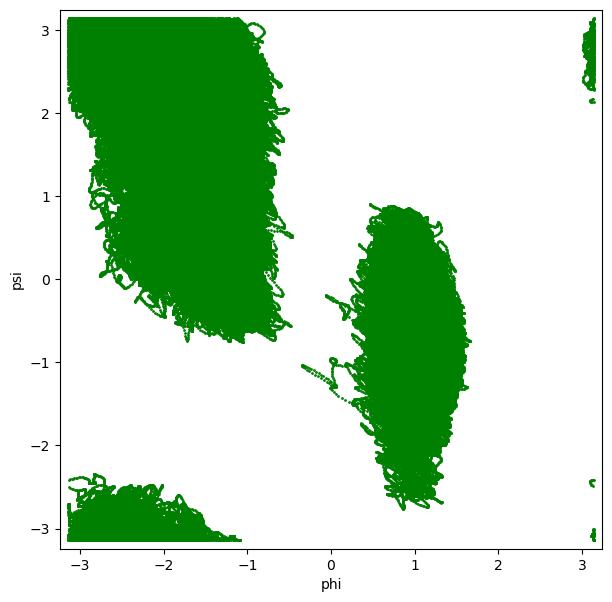

In [9]:
plt.clf()
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

ax.plot(
	traj_phi_list,
	traj_psi_list,
	marker="o",
	linestyle="None",
	markersize=1,
	alpha=1.0,
	zorder=100,
 	color="green",
)

# Plot the Ramachandran plot
plt.xlim([-np.pi - 0.1, np.pi + 0.1])
plt.ylim([-np.pi - 0.1, np.pi + 0.1])
plt.xlabel("phi")
plt.ylabel("psi")
plt.show()